In [43]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
time_elapsed_original = 0

In [44]:
spins = 10

## Construct a random lattice with spins x spins size
sigmas = np.round(np.random.rand(spins**2))*2-1
lattice = sigmas.reshape((spins, spins))

## The next function returns the total energy of the lattice
def total_energy(lat, J):
    Etot = 0

    for i in range(len(lat)):
        for j in range(len(lat)):
            if i > 0:
                Etot = Etot - (J/2)*lat[i][j]*lat[i-1][j]
            if j > 0:
                Etot = Etot - (J/2)*lat[i][j]*lat[i][j-1]
            if i < len(lat)-1:
                Etot = Etot - (J/2)*lat[i][j]*lat[i+1][j]
            if j < len(lat)-1:
                Etot = Etot - (J/2)*lat[i][j]*lat[i][j+1]

    return Etot

In [45]:
## Now, your turn

def metropolis_step(lat, J, T, kB=1):
  #lat: the input lattice
  #J: the value of the interaction J between spins
  #T: the temperature value
  E_old = total_energy(lat, J)

  j = np.random.randint(len(lat))
  i = np.random.randint(len(lat))
  lat[i][j] *= -1

  E_new = total_energy(lat, J)

  dE = E_new - E_old
  if dE < 0:
    return lat
  
  p = np.random.rand()
  if p < np.exp(-dE/(kB*T)):
    return lat
  
  lat[i][j] *= -1
  return lat

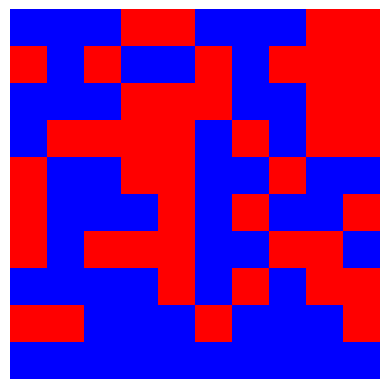

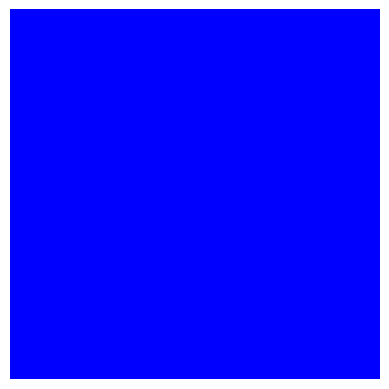

In [46]:
## With your metropolis_step function, try now to perform several steps of Monte Carlo

steps = 10000
J = 1
Temp = 0.1

## Here is a function to visualize the lattice:

def visualizer(lat):
  color_matrix = np.where(lat == 1, 0, 1)
  plt.imshow(color_matrix, cmap = 'bwr', interpolation = 'nearest')
  plt.axis('off')
  plt.show()

start_time = time.time()
visualizer(lattice)

for i in range(steps):
  lattice = metropolis_step(lattice, J, Temp)

visualizer(lattice)
time_elapsed_original = time.time() - start_time


Bonus (if interested): Representing the model as a bitboard
====

I noticed that the binary nature of the lattice lends itself to a bitboard representation. A bitboard is a concept in chess programming where the board is represented by a series of digits, which can then be manipulated using efficient bitwise operations. In this case, an $N \times N$ lattice would be represented by a series of $N^2$ bits, where 1 represents spin up and 0 represents spin down. This seems to be a common way of representing the model and I decided to try my own implementation.

Energy calculation for all at once
====

With the energy contribution of a pair of spins being $E_{pair} = \frac{J}{2}$ for mismatching spins and $E_{pair} = -\frac{J}{2}$ for matching, we can do the following generalization:
\begin{gather}
E_{pair} = \frac{J}{2} \left ( 2b - 1 \right ), \: \text{where} \: b = 
    \begin{cases} 
    1, \: \text{if spins are different} \\
    0, \: \text{if spins match}
    \end{cases}
\end{gather}

We then sum up all pairs:
\begin{gather}
E_{total}
= \frac{J}{2} \sum_i (2b_i - 1) 
= \frac{J}{2} \left( 2 \sum_i b_i - \sum_i 1 \right) 
= \frac{J}{2} (2 N_{diff} - N_{pairs})
\end{gather}

where $N_{diff}$ is the number of mismatches and $N_{pairs}$ is the total number of pairs.


Each row contributes with (N−1) horizontal pairs, and there are N rows. Same goes for vertical pairs, so we get:
\begin{gather}
N_{pairs}
= N (N - 1) + N (N - 1)
= 2 N (N - 1)
\end{gather}

Neighboring pairs can be split into horizontal and vertical pairs:
\begin{gather}
N_{diff} = N_{diff, h} + N_{diff, v}
\end{gather}

Adding this to our energy equation and simplifying, we get:
\begin{gather}
E_{total}
= J \left( N_{diff, h} + N_{diff, v} - N (N - 1) \right)
\end{gather}

Getting spin mismatches using bitwise operations
====

To compare horizontal neighbors, we shift our board one step to the right. It is then compared to the original with the XOR operation to only get the mismatches. This however stumbles upon an issue with representing a 2D model with a 1D bit array; the rightmost bit of a "row" will become the leftmost bit of the next row after shifting right. This means that instead of not having a neighbor to the right, the lefmost bit of the next row considered to be its neighbor. To counteract this we introduce a masking that removes the leftmost column in the comparison. Example:

<table style="display:inline;">
<tr><th colspan="2">Original</th></tr>
<tr><td>1</td><td>1</td></tr>
<tr><td>0</td><td>1</td></tr>
</table> 
&nbsp; XOR &nbsp;
<table style="display:inline;">
<tr><th colspan="2">Shifted</th></tr>
<tr><td>0</td><td>1</td></tr>
<tr><td>1</td><td>0</td></tr>
</table>
&nbsp; equals &nbsp; 
<table style="display:inline;">
<tr><th colspan="2">Unmasked diffs</th></tr>
<tr><td>1</td><td>0</td></tr>
<tr><td>1</td><td>1</td></tr>
</table>
<br>
<br>
<table style="display:inline;">
<tr><th colspan="2">Unmasked diffs</th></tr>
<tr><td>1</td><td>0</td></tr>
<tr><td>1</td><td>1</td></tr>
</table>
&nbsp; NAND &nbsp;
<table style="display:inline;">
<tr><th colspan="2">Masking</th></tr>
<tr><td>1</td><td>0</td></tr>
<tr><td>1</td><td>0</td></tr>
</table>
&nbsp; equals &nbsp; 
<table style="display:inline;">
<tr><th colspan="2">Actual diffs</th></tr>
<tr><td>0</td><td>0</td></tr>
<tr><td>0</td><td>1</td></tr>
</table>

Same principle applies for vertical mismatches, although we shift N steps instead (I.E. same column, one row below). Since the top row then will be filled with zeros, we mask that too (this time AND instead of NAND since that mask is easier to get).
<table style="display:inline;">
<tr><th colspan="2">Original</th></tr>
<tr><td>1</td><td>1</td></tr>
<tr><td>0</td><td>1</td></tr>
</table> 
&nbsp; XOR &nbsp;
<table style="display:inline;">
<tr><th colspan="2">Shifted</th></tr>
<tr><td>0</td><td>0</td></tr>
<tr><td>1</td><td>1</td></tr>
</table>
&nbsp; equals &nbsp; 
<table style="display:inline;">
<tr><th colspan="2">Unmasked diffs</th></tr>
<tr><td>1</td><td>1</td></tr>
<tr><td>1</td><td>0</td></tr>
</table>
<br>
<br>
<table style="display:inline;">
<tr><th colspan="2">Unmasked diffs</th></tr>
<tr><td>1</td><td>1</td></tr>
<tr><td>1</td><td>0</td></tr>
</table>
&nbsp; AND &nbsp;
<table style="display:inline;">
<tr><th colspan="2">Masking</th></tr>
<tr><td>0</td><td>0</td></tr>
<tr><td>1</td><td>1</td></tr>
</table>
&nbsp; equals &nbsp; 
<table style="display:inline;">
<tr><th colspan="2">Actual diffs</th></tr>
<tr><td>0</td><td>0</td></tr>
<tr><td>1</td><td>0</td></tr>
</table>

Now we can perform these operations and count the number of mismatches (number of ones in the final bit series). Inserting these in the equation for $E_{total}$ will then give the total energy of the configuration. Since this limits the number of operations for the energy calculation to two, this should increase performance considerably. A small time analysis will be included below.

In [47]:
def get_masks():
    left_mask = sum(1 << (i * spins + (spins-1)) for i in range(spins)) #eg 1000 1000 1000 1000 for spins=4
    top_mask = (1 << (spins * (spins - 1))) - 1 #0000 1111 1111 1111 for spins=4
    return left_mask, top_mask

def bitwise_energy(board, J, left_mask, top_mask):
  # check horizontal neighbors: shift right (>>1) but mask edges
  hdiff = (board ^ (board >> 1)) & ~left_mask
  num_diff_h = hdiff.bit_count() 
  # vertical neighbors: shift down (>>spins) but mask top row
  vdiff = (board ^ (board >> spins)) & top_mask  
  num_diff_v = vdiff.bit_count()

  return J * (num_diff_h + num_diff_v - spins * (spins-1))

def bitwise_metropolis_step(board, J, T, kB, no_of_bits, left_mask, top_mask):
  E_old = bitwise_energy(board, J, left_mask, top_mask)

  j = np.random.randint(no_of_bits) # pick a random position in the lattice to flip
  bit_swap = 1 << j #shift 1 to the left j times (eg j=4 -> 1 0000)
  board ^= bit_swap

  E_new = bitwise_energy(board, J, left_mask, top_mask)

  dE = E_new - E_old
  if dE < 0:
    return board
  
  p = np.random.rand()
  if p < np.exp(-dE/(kB*T)):
    return board
  
  board ^= bit_swap
  return board

In [48]:
steps = 10000
J = 1
T = 0.1
kB = 1
no_of_bits = spins**2
board = random.getrandbits(no_of_bits) 
left_mask, top_mask = get_masks()

def bitwise_visualizer(board):
  for i in range(spins): #row-wise rendering
    row = ""
    for j in range(spins):
      row += str((board >> (j+(spins*i))) & 1) #shift bit at (i, j) to the least significant bit and get least significant bit 
    print(row)

start_time = time.time()
print("Initial state:")
bitwise_visualizer(board)

for i in range(steps):
  board = bitwise_metropolis_step(board, J, T, kB, no_of_bits, left_mask, top_mask)

print("\nFinal state:")
bitwise_visualizer(board)
time_elapsed_bitwise = time.time() - start_time
print(f"\nTime elapsed for iteration method: {time_elapsed_original} seconds")
print(f"\nTime elapsed for bitwise method: {time_elapsed_bitwise} seconds")
print(f"\nBitwise method takes {round(100*time_elapsed_bitwise/time_elapsed_original, 2)} % of the time of the iteration method")



Initial state:
1110011001
0101111110
0100011101
1110110101
0010001101
0111001110
0111110000
0001100010
0100100100
1000100010

Final state:
0000000000
0000000000
0000000000
0000000000
0000000000
0000000000
0000000000
0000000000
0000000000
0000000000

Time elapsed for iteration method: 2.5805752277374268 seconds

Time elapsed for bitwise method: 0.0321650505065918 seconds

Bitwise method takes 1.25 % of the time of the iteration method
